
# No Show Appointments **Capstone Edition**
Amanda Bowman


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#load">Load and Explore the Data</a></li>
<li><a href="#clean">Cleaning</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#eda">Preprocessing</a></li> 
<li><a href="#eda">Data Model</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#sources">Sources</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This dataset is a simplified version of the Medical Appointment No Shows dataset on kaggle. It contains data for 110,527 unique appointments with 14 associated values for different characteristics. It was most recently updated six years ago. One item of note when viewing this dataset is that the value of the No Show column indicates whether the patient no-showed for the appointment. This means that "Yes" or, later, True mean that the patient did NOT attend the appointment.

#### Descriptive information about each column

| Column Name     | Description   | Original Datatype | Final Datatype |
|:-----           |:-----         |:-------           |:--------       |
|PatientId      |Identification of a patient   | float             | string            |
| AppointmentID  | Identification of each appointment         | int               | string            |
| Gender         | Male or Female .    | string            | int         |
| ScheduledDay   | The day someone called or registered the appointment, this should be before appointment.      | string            | datetime       |
| AppointmentDay | The day of the actual appointment, when they have to visit the doctor.                                                                                                                                                 | string            | datetime       |
| Age            | How old is the patient.                                                | int               | int            |
| Neighbourhood  | Where the appointment takes place.                                                 | string            | int           |
| Scholarship    | 0 or 1 .  True indicates enrollment in the social program Bolsa Familia. Between 2003 and 2021, Bolsa Familia supported families with children ages 0-17 living in poverty (monthly income between R$85.01 and R$170.00) and in extreme poverty  (monthly income equal to or less than R$85.00).  Note: To maintain eligibility, children must receive vaccinations on schedule and maintain attendance in school. For children between the ages of 6 and 15, they must meet a 85\%   attendance expectation. Children aged between 16 and 17  must meet a 75\% attendance expectation.  | int               | int           |
| Hipertension   |0 or 1     | int               | int           |
| Diabetes       | 0 or 1     | int               | int           |
| Alcoholism     | 0 or 1     | int               | int           |
| Handcap        | 0-4    | int               | int           |
| SMS_received   | 0 or 1 | int               | int           |
| No-show        | Yes or No. Yes means patient no-showed for the appointment.      | string            | int           |


For additional details about the data set, including the data dictionary:
[kaggle](https://www.kaggle.com/datasets/joniarroba/noshowappointments)
[Project Description](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub)

### Question(s) for Analysis

1) Which factors or characteristics have a positive relationship with no shows? 

2) Is there a relationship between the length of time between scheduling the appointments and appointment attendance? Do people who receive text message reminders attend more frequently and does this relate no shows to the length of time?


### Import the required packages

In [1]:
#!pip install --upgrade pandas==1.3.5
#!pip install --upgrade scikit-learn
#!pip install --upgrade seaborn
#!pip install --upgrade matplotlib

In [2]:
from platform import python_version

print(python_version())

3.8.16


In [3]:
# set up import statements for all of the packages that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

%matplotlib inline

In [229]:
# set some variables
fig_dims = (12,5)

<a id='load'></a>
## Load and Explore the Data

In [4]:
# Load data and print out a few lines to get a basic understanding of the dataset and ensure loading:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
# Understand basic features of dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
# View statistical information about the columns.
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


While several of these columns are integers, they appear to represent categorical data. What are the possible values?

In [7]:
columns = ['Gender','Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']
for col in columns:
    col_values = str(col) + ': ' + str(pd.unique(df[col])) 
    print(col_values) 
    print()  # cycle through each column and print the concatenated string

Gender: ['F' 'M']

Neighbourhood: ['JARDIM DA PENHA' 'MATA DA PRAIA' 'PONTAL DE CAMBURI' 'REPÚBLICA'
 'GOIABEIRAS' 'ANDORINHAS' 'CONQUISTA' 'NOVA PALESTINA' 'DA PENHA'
 'TABUAZEIRO' 'BENTO FERREIRA' 'SÃO PEDRO' 'SANTA MARTHA' 'SÃO CRISTÓVÃO'
 'MARUÍPE' 'GRANDE VITÓRIA' 'SÃO BENEDITO' 'ILHA DAS CAIEIRAS'
 'SANTO ANDRÉ' 'SOLON BORGES' 'BONFIM' 'JARDIM CAMBURI' 'MARIA ORTIZ'
 'JABOUR' 'ANTÔNIO HONÓRIO' 'RESISTÊNCIA' 'ILHA DE SANTA MARIA'
 'JUCUTUQUARA' 'MONTE BELO' 'MÁRIO CYPRESTE' 'SANTO ANTÔNIO' 'BELA VISTA'
 'PRAIA DO SUÁ' 'SANTA HELENA' 'ITARARÉ' 'INHANGUETÁ' 'UNIVERSITÁRIO'
 'SÃO JOSÉ' 'REDENÇÃO' 'SANTA CLARA' 'CENTRO' 'PARQUE MOSCOSO'
 'DO MOSCOSO' 'SANTOS DUMONT' 'CARATOÍRA' 'ARIOVALDO FAVALESSA'
 'ILHA DO FRADE' 'GURIGICA' 'JOANA D´ARC' 'CONSOLAÇÃO' 'PRAIA DO CANTO'
 'BOA VISTA' 'MORADA DE CAMBURI' 'SANTA LUÍZA' 'SANTA LÚCIA'
 'BARRO VERMELHO' 'ESTRELINHA' 'FORTE SÃO JOÃO' 'FONTE GRANDE'
 'ENSEADA DO SUÁ' 'SANTOS REIS' 'PIEDADE' 'JESUS DE NAZARETH'
 'SANTA TEREZA' 'CRUZAMENTO' 'IL

In [8]:
# Number of duplicate rows?
sum(df.duplicated())

0

In [9]:
# Missing data?
df.isna().any(axis=1).sum() 

0

In [10]:
# Check the number of unique patients versus the number of unique appointments to determine how these columns relate.
print('Number of unique patients: ', df['PatientId'].nunique())
print('Number of unique appointments: ', df['AppointmentID'].nunique())

Number of unique patients:  62299
Number of unique appointments:  110527


This indicates that each appointment is only linked to one patient, but one patient can have many appointments.

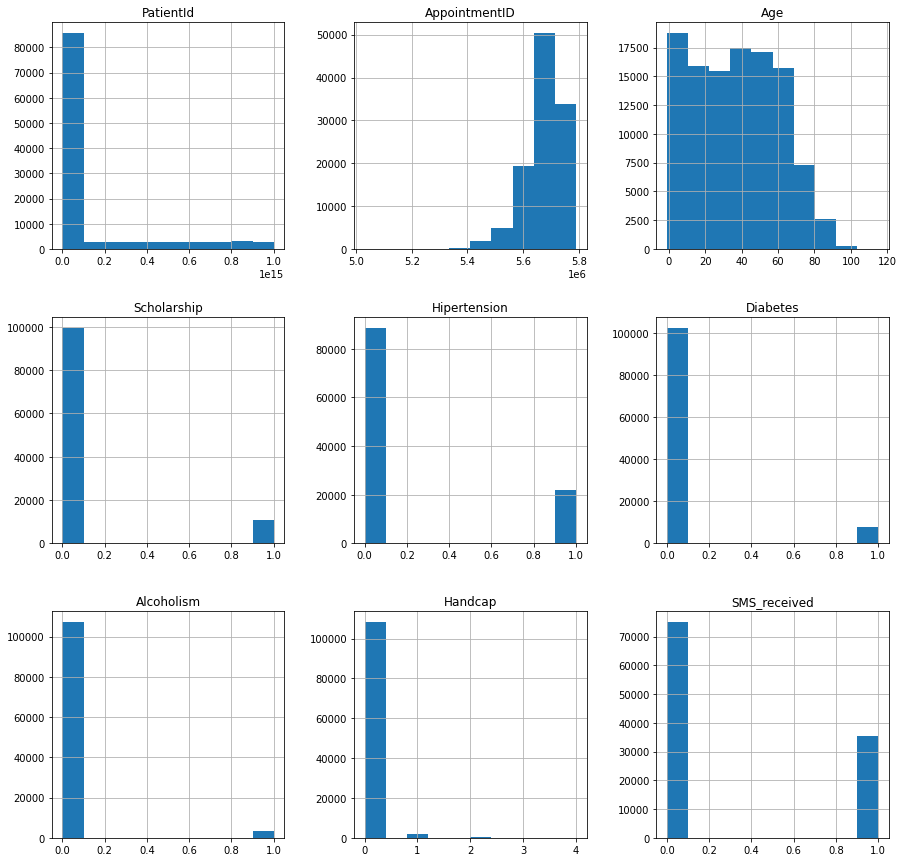

In [11]:
# Histograms of each column to better understand the data and distributions for each column. AppointmentID and PatientId will have no meaning.
df.hist(figsize=(15,15));


# Possibly analyze duplicate patient data

In [12]:
dup_pts = df[df['PatientId'].duplicated(keep=False)]
dup_pts.sort_values('PatientId')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58616,2.263866e+07,5580835,F,2016-04-14T07:23:30Z,2016-05-03T00:00:00Z,22,INHANGUETÁ,0,0,0,0,0,1,No
88585,2.263866e+07,5715081,F,2016-05-18T13:37:12Z,2016-06-08T00:00:00Z,23,INHANGUETÁ,0,0,0,0,0,1,No
83628,5.216894e+07,5704816,F,2016-05-16T16:42:19Z,2016-05-16T00:00:00Z,28,JARDIM DA PENHA,0,0,0,0,0,0,No
49826,5.216894e+07,5607220,F,2016-04-20T11:22:15Z,2016-05-17T00:00:00Z,28,JARDIM DA PENHA,0,0,0,0,0,0,No
11009,6.485121e+07,5683383,F,2016-05-11T07:28:23Z,2016-05-13T00:00:00Z,29,MARUÍPE,0,0,0,0,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32033,9.999320e+14,5736368,M,2016-05-25T08:14:58Z,2016-05-25T00:00:00Z,90,JABOUR,0,0,0,0,0,0,No
32023,9.999320e+14,5710157,M,2016-05-17T15:22:01Z,2016-05-17T00:00:00Z,90,JABOUR,0,0,0,0,0,0,No
62194,9.999320e+14,5616762,M,2016-04-25T14:46:41Z,2016-05-04T00:00:00Z,90,JABOUR,0,0,0,0,0,1,No
104616,9.999320e+14,5772701,M,2016-06-03T16:04:03Z,2016-06-07T00:00:00Z,90,JABOUR,0,0,0,0,0,1,No


In [13]:
prev_ns = []



In [22]:
def plot_dist(df, col_name, width_bin):
    sns.displot(data=df, x=col_name, binwidth=width_bin, height=5, aspect=11.7/5);

<a id='clean'></a>
## Cleaning and Wrangling

As identified above, there are no duplicate rows and no missing values. My data will require some wrangling before it is ready for use in a model. I will address some general issues and perform initial feature engineering on the date columns.

#### Update Column Names and Drop ID columns

 
 * Column Headers:
     - Capitalized - need to make lower case
     - Need to separate PatientId, AppointmentID, ScheduledDay, AppointmentDay with _
     - Change No-show to no_show     
     - Update Hipertension and Handcap column names
     

     




     - sheduled_day and appointment_day to datetime
     - scholarship, hipertension, diabetes, alcoholism, sms_received, no_show to bool
     


In [136]:
# Make a copy of the data
df_prep = df.copy()

In [137]:
# Make all column names lower case and replace the dash with an underscore.
df_prep.rename(columns= lambda x:x.lower().replace("-", "_"), inplace=True)
# Rename the rest of columns by adding an underscore and update column names. 
df_prep.rename(columns={'scheduledday':'scheduled_day', 'appointmentday':'appointment_day', 'hipertension':'hypertension', 'handcap':'disability_count'}, inplace=True)
# Check new column names.
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   patientid         110527 non-null  float64
 1   appointmentid     110527 non-null  int64  
 2   gender            110527 non-null  object 
 3   scheduled_day     110527 non-null  object 
 4   appointment_day   110527 non-null  object 
 5   age               110527 non-null  int64  
 6   neighbourhood     110527 non-null  object 
 7   scholarship       110527 non-null  int64  
 8   hypertension      110527 non-null  int64  
 9   diabetes          110527 non-null  int64  
 10  alcoholism        110527 non-null  int64  
 11  disability_count  110527 non-null  int64  
 12  sms_received      110527 non-null  int64  
 13  no_show           110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Address Age
 
 Age is an integer variable starting at 0. There were patients aged under 0 and over 100 years old. 115 years old seems like a potential error.

The number of patients between the ages of 100 and 120 is very small. What can I learn about those patients to determine whether they need to be dropped from the dataset as errors?

What are the ages of the patient for the 10 oldest-aged appointments?

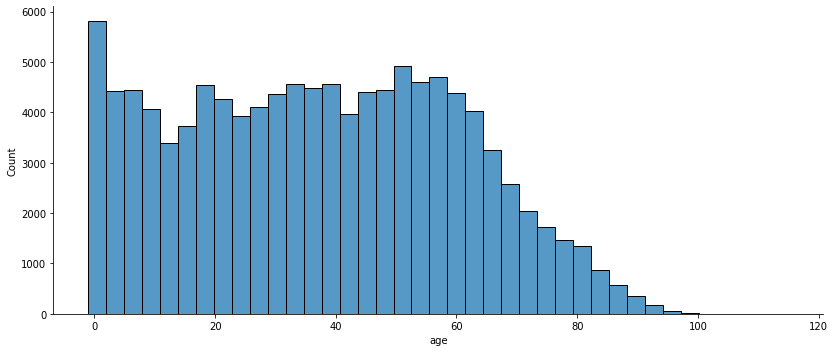

In [138]:
# What does the distribution of ages look like?
plot_dist(df_prep,'age', 3)

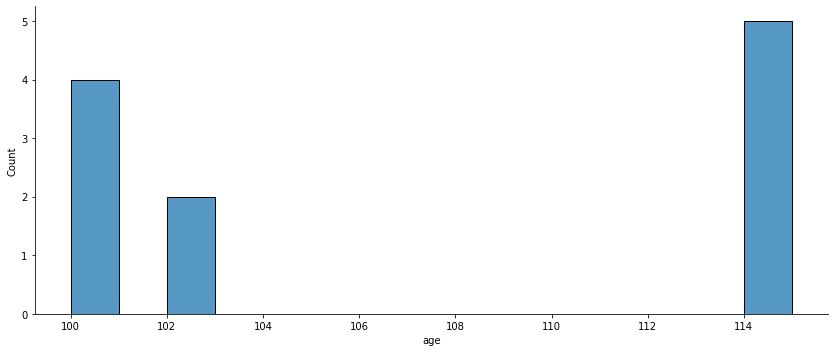

In [139]:
#The number of patients between the ages of 100 and 120 is very small. 
#What can I learn about those patients to determine whether they need to be dropped from the dataset as errors?
plot_dist(df_prep[df_prep['age'] >= 100], 'age', 1)

In [140]:
df_prep[df_prep['age'] >= 102]

,patientid,appointmentid,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
58014,9.762948e+14,5651757,F,2016-05-03T09:14:53Z,2016-05-03T00:00:00Z,102,CONQUISTA,0,0,0,0,0,0,No
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
90372,2.342836e+11,5751563,F,2016-05-31T10:19:49Z,2016-06-02T00:00:00Z,102,MARIA ORTIZ,0,0,0,0,0,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


Based on patientid, the max age of 115 is for two distinct patients, one with multiple appointments. The next oldest is 102. While it is possible that this age is correct, reviewing [World Age Statistics] (https://en.wikipedia.org/wiki/Oldest_people#:~:text=The%20oldest%20living%20person%20in,Venezuela%2C%20born%2027%20May%201909.) indicates it is unlikely to have even one person of this age in this data, let alone two. It is impossible to determine whether these ages were entered in error, so it will be necessary to remove these rows. Since the next oldest patient is 102 and there are 6 patients between the ages of 100 and 102, I will use this as a cutoff. 

In [141]:
df_prep.drop(df_prep[df_prep['age'] > 102].index, inplace = True)
df_prep.drop(df_prep[df_prep['age'] < 0].index, inplace = True)

In [142]:
df_prep['age'].describe()

count    110521.000000
mean         37.085694
std          23.104606
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         102.000000
Name: age, dtype: float64

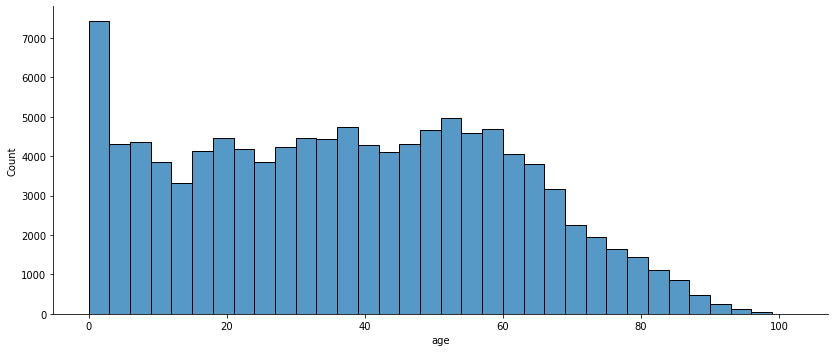

In [143]:
plot_dist(df_prep,'age', 3)

#### ID Columns
Since each row represents one appointment, I can drop the appointment and patient id columns.

In [144]:
# Drop appointment and patient id columns
df_prep.drop(columns=['appointmentid', 'patientid'], inplace=True)

### Date Feature Engineering
 
Discrete dates will not be helpful for predicting future no-shows. The day of the week that the appointment was scheduled or that the patient called to schedule may be relevant. Columns with this data will be created. The time lapse between when the appointment is made and the appointment date likely does have a relationship with no shows. A time lapse column will be created to leverage the date information.

 * Need to be converted to DateTime
 * Extract day of the week for `scheduled_day` and `appointment_day`
 * Create new int col for number of days between scheduled and appt
 * Drop date columns

In [145]:
# convert to DateTime
df_prep['scheduled_day'] = pd.to_datetime(df_prep['scheduled_day'])
df_prep['appointment_day'] = pd.to_datetime(df_prep['appointment_day'])
df_prep.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [146]:
# What is the range of dates for the set?
df_prep['appointment_day'].agg(['min', 'max'])

min   2016-04-29 00:00:00+00:00
max   2016-06-08 00:00:00+00:00
Name: appointment_day, dtype: datetime64[ns, UTC]

In [147]:
# Could the day of the week for scheduling or the appointment day be relevant?
df_prep['appointment_weekday'] = df_prep['appointment_day'].dt.dayofweek
df_prep['scheduled_weekday'] = df_prep['scheduled_day'].dt.dayofweek

In [148]:
df_prep.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4


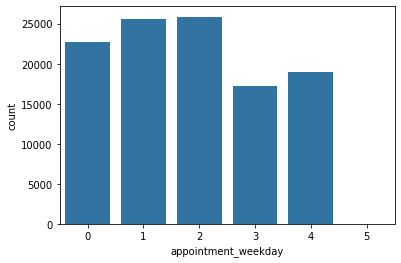

In [149]:
sns.countplot(data=df_prep, x='appointment_weekday');

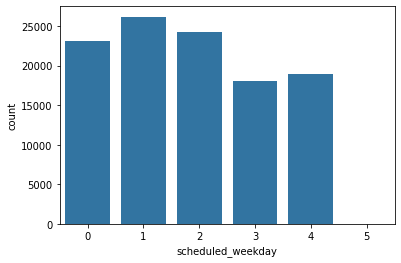

In [150]:
sns.countplot(data=df_prep, x='scheduled_weekday');

In [153]:
# Create new column for the number of days between scheduling and the actual appointment. 
df_prep['days_between'] = (df_prep['appointment_day'] - df_prep['scheduled_day']).dt.days.astype(int)

#View the statistical information about the new column.
df_prep['days_between'].describe()

count    110521.000000
mean          9.183721
std          15.255082
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64

Appointment_day does not have time included but scheduled_day does. This is causing a -1 in days_between. This value should be 0 to indicate that the appointment was scheduled on the same day. Any rows with a negative number after -1 has been replaced with 0 are erroneous and need to be removed.

In [154]:
# Replace rows with -1 for same day with 0
df_prep['days_between'].replace(-1, 0, inplace=True)

In [155]:
# Drop rows with appointment dates prior to scheduling dates
df_prep.drop(df_prep[df_prep['days_between'] < 0].index, inplace = True)

In [156]:
# Verify
df_prep['days_between'].describe()

count    110516.000000
mean          9.533190
std          15.028018
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: days_between, dtype: float64

In [157]:
# Drop date columns
df_prep.drop(columns=['appointment_day', 'scheduled_day'], inplace=True)
df_prep.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday,days_between
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4,0


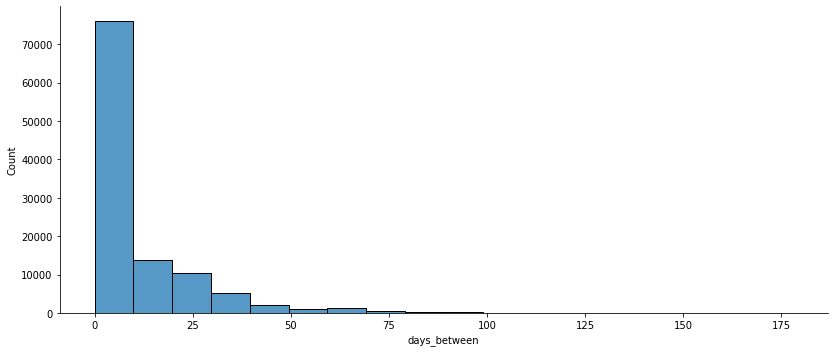

In [158]:
# distribution of days between
# Note: This data is highly skewed and will require transformation
plot_dist(df_prep, 'days_between', 10)

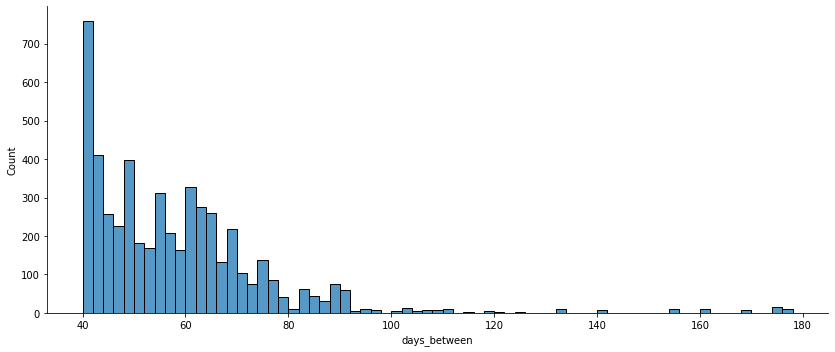

In [159]:
# distribution of days between greater than approximately 2 std above the mean
plot_dist(df_prep[df_prep['days_between'] >= 40], 'days_between', 2)

In [161]:
# Make a pre-dummies dataframe for EDA
df_eda = df_prep.copy()
df_engineer = df_prep.copy()

<a id='eda'></a>
## Exploratory Data Analysis

In [ ]:
# Create a truncated copy of the DataFrame with no neighbourhood columns
df_eda.head()

In [ ]:
def plot_proportion(column):
    fig, ax = plt.subplots(figsize=[10,5])
    sns.countplot(x=column, data=df_eda, hue='no_show', stat='proportion');
    ax.legend(labels=['No', 'Yes'], title='Did the patient No Show?')
    for container in ax.containers:
        ax.bar_label(container)

In [ ]:
# Proportion of no shows by gender
plot_proportion('gender')

In [ ]:
# Proportion of no shows by age
plot_proportion('age')

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=2, sharey=True, figsize=[15,12])

def plot_proportion(column, ax):
    sns.countplot(x=column, data=df_eda, hue='no_show', stat='proportion', ax=ax);

for i, column in enumerate(df_eda.columns):
    row = i //2
    col = i % 2
    ax = axes[row, col]
    plot_proportion(column, ax)

In [ ]:
for i, col in enumerate(df_eda.columns):
    print (i, col)

In [ ]:
axes.flatten()

In [ ]:
fig = plt.figure()
example_list = [[1,2,3],[4,5,6],[3,2,5],[5,2,3],[1,3,1],[5,3,5]]

for i,data in enumerate(example_list):
    ax = plt.subplot(2,3,i+1)
    ax.plot(data)

In [ ]:
def draw_line(ax,array):
    # fig, ax = plt.subplots()
    ax.plot(array)

# example data and figure
example_list = [[1,2,3],[4,5,6],[3,2,5],[3,2,5],[3,2,5],[3,2,5]]
fig, axes = plt.subplots(nrows=2, ncols=3)

# loop over elements in subplot and data, plot each one
for ax,i in zip(axes.flatten(),example_list):
    draw_line(ax,i) 

In [ ]:
df_eda.column()

In [ ]:
eda_columns = list(df_eda.columns)
eda_columns

In [ ]:
fig, ax = plt.subplots(
    
    
for col in 
    i=0

In [ ]:
sns.countplot(x='gender', data=df_eda, hue='no_show', stat='percent');

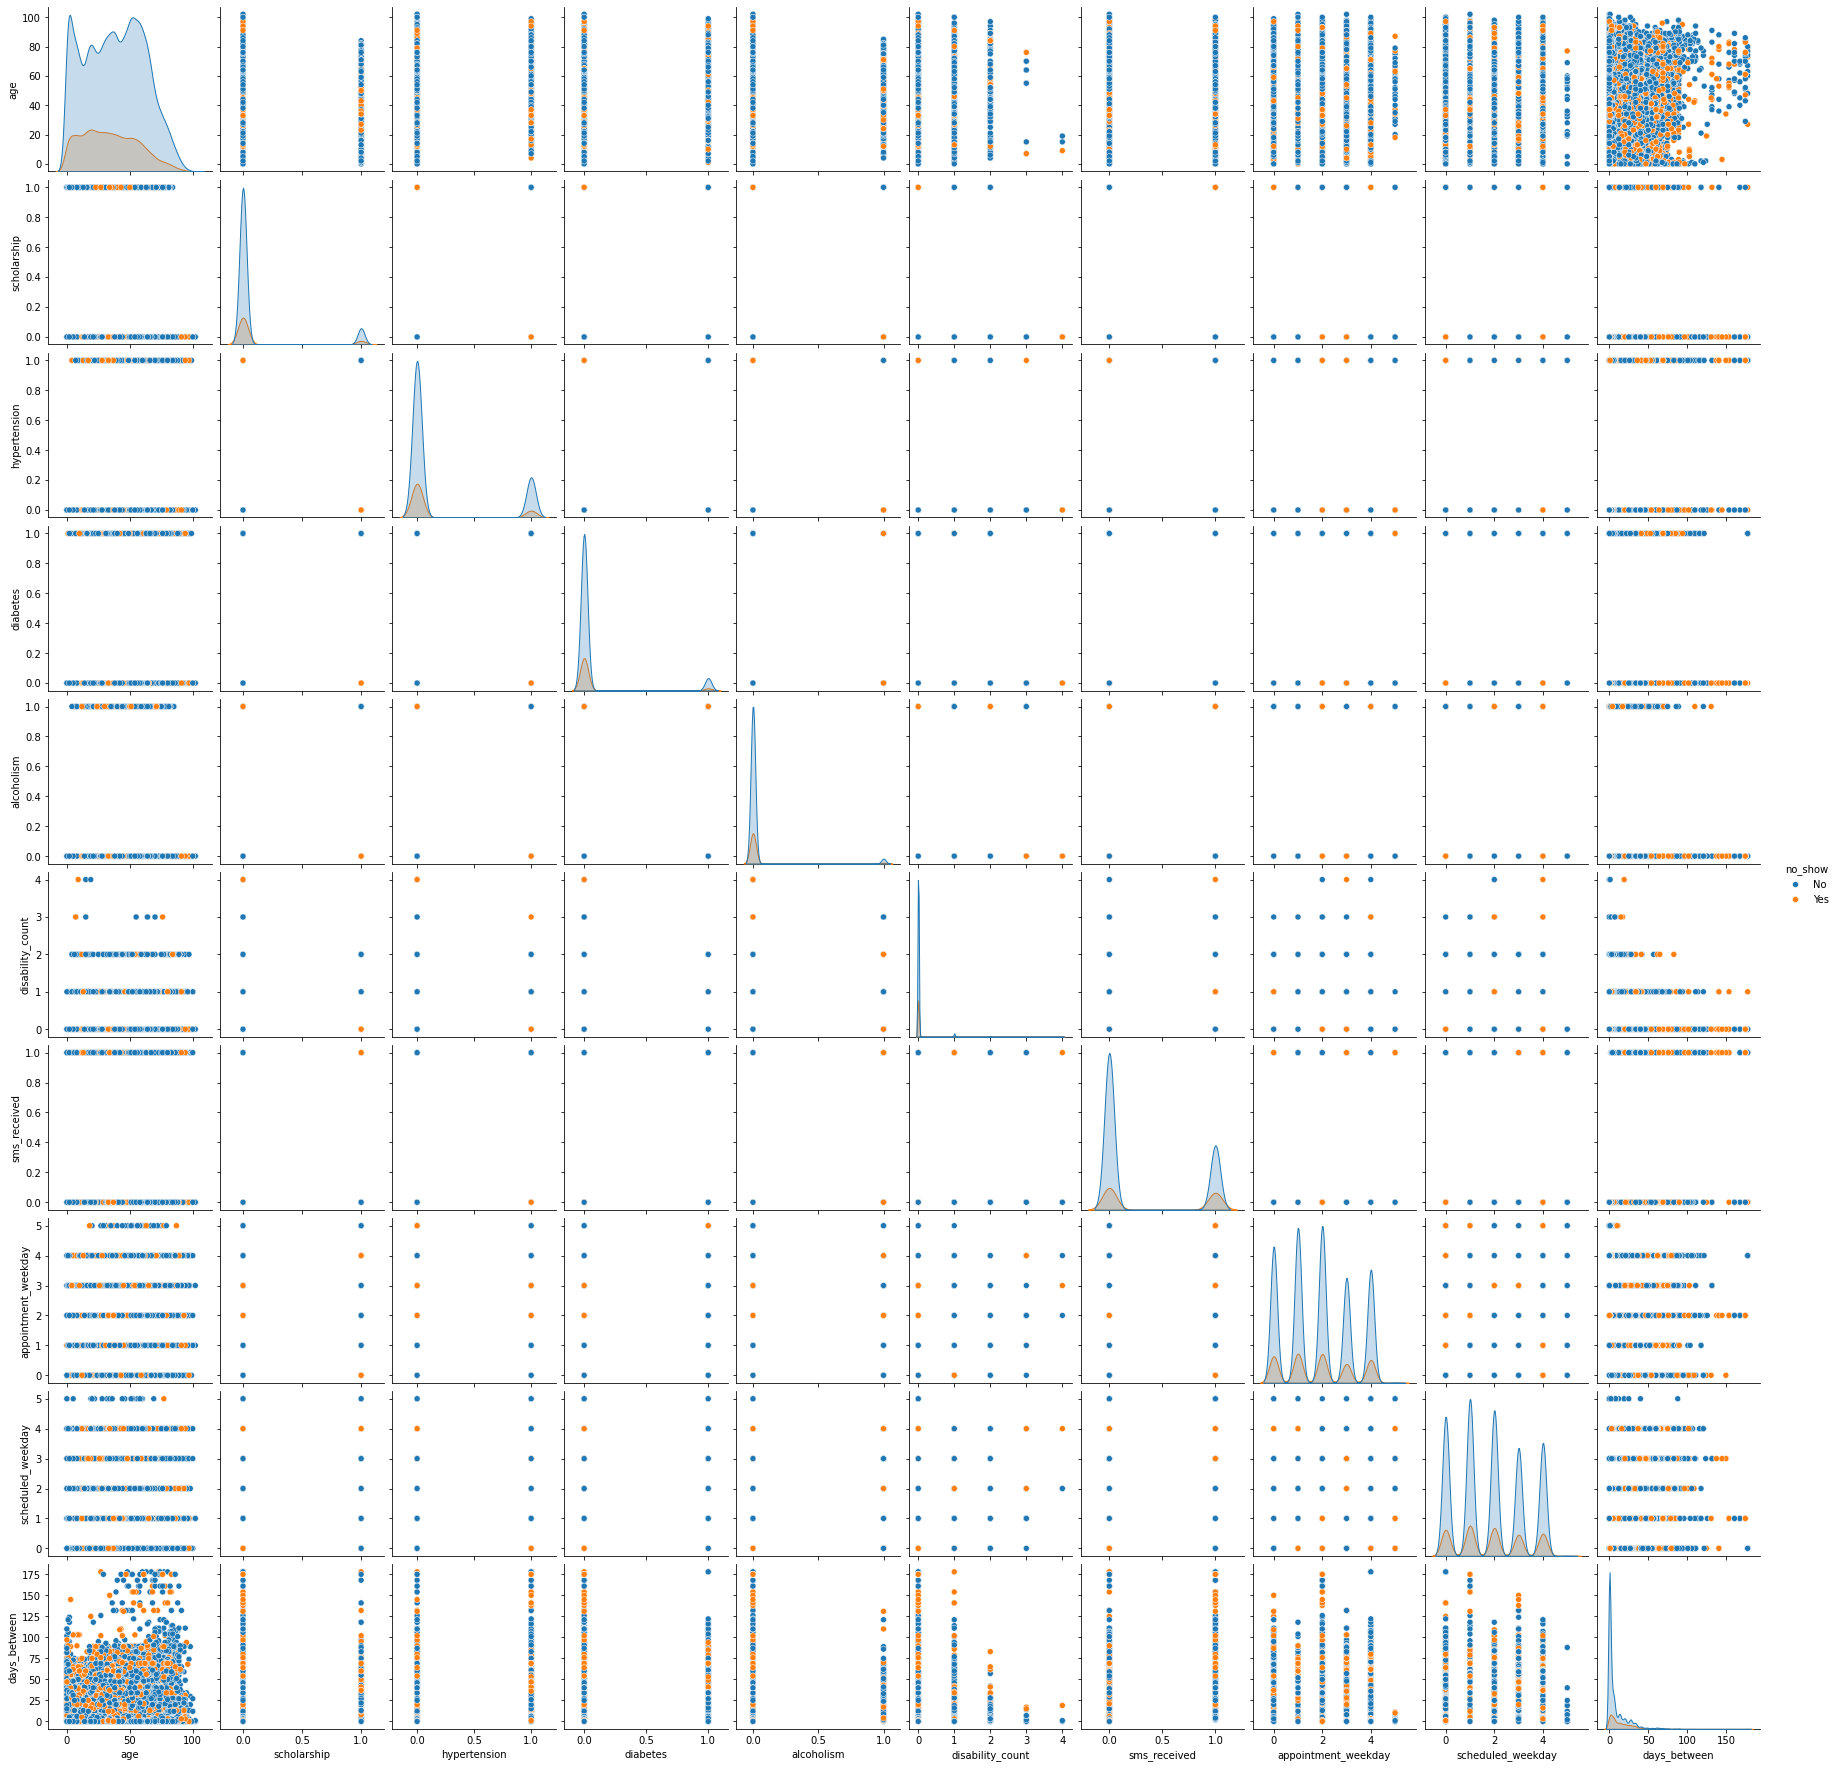

In [140]:
sns.pairplot(data=df_eda, hue='no_show');

Create functions for charting the data.

In [ ]:
col_colors = ['blue', 'green'] # initialize col_colors for the columns

In [ ]:
def appt_count(col): ## creates a bar plot of a column 
    sns.countplot(x=col, data=df_eda, hue='no_show', stat='percent');
    plt.title('Proportion No-Showed')
    
def pie_chart(col): ## creates a pie chart for the overall percentage of each value of a column
    df[col].value_counts().plot(kind='pie', 
                                autopct='%1.1f%%', 
                                colors=col_colors,
                                );
        
def noShowFactor(col): ## creates a figure with both the pie chart and the bar chart
    my_ticks = list(pd.unique(df_eda[col])) 
    
    plt.figure(figsize=(20, 8)) # define size of figure
    plt.subplot(1,2,1) # defines orientation - one row, 2 subplots, first position (left)
    pie_chart(col)
        
    plt.subplot(1, 2, 2) # defines orientation - one row, 2 subplots, second position (right)
    appt_count(col)

In [ ]:
pie_chart('gender')

### Research Question 1: Which factors or characteristics have a positive relationship with no shows?

#### Overview of No Shows for all appointments

How many and what percent of the appointments are no shows?

In [ ]:
ns_labels = ['Attended', 'Did Not Attend'] # labels for both pie chart and bar chart
ns_heights = df['no_show'].value_counts() # number of rows sorted by no_show

plt.figure(figsize = [20,8]) # define size of figure
plt.subplot(1, 2, 1) # defines orientation - one row, 2 subplots, first position (left)
g1 = pie_chart('no_show', 'Attendance Percentage of All Appointments', ns_labels)
plt.legend()

plt.subplot(1, 2, 2) # defines orientation - one row, 2 subplots, second position (right)
g2 = appt_count(ns_heights, 'Overall Appointment Attendance', 'Attendance', 'Number of Appointments', ns_labels)

Patients no showed for approximately 20% or 1/5 of the scheduled appointments, without taking any other factors into consideration. 

Lets breakdown no shows based on other personal characteristics.

#### Gender

In [ ]:
sns.countplot(x='Gender', data=df, hue='No-show')

More appointments were for women. The proportion of no shows by gender appears to be roughly even.

#### Age

In [ ]:
age_heights = char_proportion('age')
age_ticks = age_heights.index
plt.figure(figsize=(26,8))
nocolor_appt_count(age_heights, 'Comparison of Appointment No Shows by Age', 'Age in Years', 'Proportion of No Shows', age_ticks)


There appears to be a positive skew indicating that younger ages have a higher percentage of no shows. There are, however, clear outliers in the older ages.

#### Enrollment in Bolsa Familia (Scholarship)

In [ ]:
noShowFactor('scholarship', 
             'Comparison of Appointment No Shows by Enrollment in Bolsa Familia', 
             'Percentage of Bolsa Familia Enrollment for All Appointments', 
             'Bolsa Familia Status', 
             'Proportion of No Shows')

Only about 10% of appointments were for patients enrolled in Bolsa Familia and thus considered to be living in poverty or extreme poverty. These patients had a higher no show rate than patients not enrolled.

#### Hypertension

In [ ]:
noShowFactor('hypertension', 
             'Comparison of Appointment No Shows by Hypertension Status', 
             'Percentage of Hypertension Status for All Appointments', 
             'Hypertension Status', 
             'Proportion of No Shows')

Patients with hypertension had close to 20% of the scheduled appointments. These patients had a lower no show rate than patients without hypertension.

#### Diabetes

In [ ]:
noShowFactor('diabetes', 
             'Comparison of Appointment No Shows by Diabetes Status', 
             'Percentage of Diabetes Status for All Appointments', 
             'Diabetes Status', 
             'Proportion of No Shows')

Only 7.2% of appointments were for patients with diabetes. Patients with diabetes had a lower proportion of missed appointments.

#### Alcoholism

In [ ]:
noShowFactor('alcoholism', 
             'Comparison of Appointment No Shows by Alcoholism Status', 
             'Percentage of Alcoholism Status for All Appointments', 
             'Alcoholism Status', 
             'Proportion of No Shows')

Appointments for patients with identified alcoholism made up 3% of the total appointments scheduled. The proportion of no shows for these patients was equal to the proportion of patients without alcoholism.

#### Number of Disabilities

In [ ]:
noShowFactor('disability_count', 
             'Comparison of Appointment No Shows by Number of Disabilities', 
             'Percentage of Number of Disabilities for All Appointments', 
             'Number of Disabilities', 
             'Proportion of No Shows')

The overall percentage of appointments for people with one or more disabilities was 2%, with fewer appointments for people as disabilities increased. The proportion of appointments missed for patients with one disability was lower than patients with none, but the proportion increased from that point. This could reflect the increased difficulties associated with each additional disability the patient had.

#### Text Message Reminder Received

In [ ]:
noShowFactor('sms_received', 
             'Comparison of Appointment No Shows by SMS Reminder Receipt', 
             "Percentage of SMS Reminder Receipt for All Appointments", 
             'SMS Receipt', 
             'Proportion of No Shows')

SMS messages were sent to patients for 32.1% of appointments. Patients who received a text message had a higher proportion of no shows.

### Research Question 2: Is there a relationship between the length of time between scheduling the appointments and appointment attendance? Do people who receive text message reminders attend more frequently and does this relate no shows to the length of time?

I created an additional column for days_between scheduling the appointment and the appointment date during Data Wrangling. I will start by viewing the descriptive statistics for this column.

#### Days Between Scheduling and the Appointment

In [ ]:
df['days_between'].describe()

The max number of days between scheduling and the date of the appointment is 178. However, 75% of appointments were scheduled within 14 days and the standard deviation is 15. I will start by viewing the distribution for all of the days, but will then look at just the days within the first standard deviation.

In [ ]:
df['days_between'].hist();

As expected, the vast majority of the appointments were scheduled closely to the actual appointment date.

Diving deeper, here is the distribution of appointments for appointments scheduled within two standard deviations of the scheduling date.

In [ ]:
days_df = df.query('days_between <= 30') # also creating a dataframe for appointments scheduled within two standard deviation
days_df['days_between'].hist();

I can use functions created above to help answer these questions, as well.

#### Missed Appointments by Number of Days Between Scheduling and the Appointment



In [ ]:
days_height = char_proportion('days_between')
days_title = 'Proportions of Missed Appointments by Number of Days Between Scheduling and the Appointment'
days_xlabel = 'Number of Days Between Scheduling the Appointment and the Appointment Date'
days_ylabel = 'Proportion of Missed Appointments'
days_ticks = days_height.index

plt.figure(figsize=(20,5))
nocolor_appt_count(days_height,
          days_title,
          days_xlabel,
          days_ylabel,
          days_ticks)


As evidenced by the chart above, including the days outside even two standard deviations makes the graph unmanageable. As a result, I am going to make a copy of the char_proportion function that allows me to input the desired dataframes. This will allow me to define a function to chart proportions with days_between within two standard deviations.

In [ ]:
#Remember:
#def char_proportion(col): ## creates a dataframe with the proportions of no shows for each value of a column
    #counts = df_noshow.groupby(col).count() # counts the total number of no shows for each value
    #char_counts = df.groupby(col).count() # counts the total number of rows with each value
    #proportions = counts /char_counts # calculates the proportion
    #return proportions['no_show'] 
    
# Take a dataframe where days_between is less than 30 (days_df created above) and create one where no show = True 
df_days_noshow = days_df.query('no_show == True')
    
def days_proportion(col, counts_df, char_counts_df ):
    days_counts = counts_df.groupby(col).count() # counts the total number of no shows for each value, eg. df_days_noshow
    days_char_counts = char_counts_df.groupby(col).count() # counts the total number of rows with each value, eg. days_df
    days_proportions = days_counts / days_char_counts # calculates the proportion
    return days_proportions['no_show']

def prop_days_chart(pdays_height, title):
    pdays_title = title
    pdays_xlabel = 'Number of Days Between Scheduling the Appointment and the Appointment Date'
    pdays_ylabel = 'Proportion of Missed Appointments'
    pdays_ticks = pdays_height.index

    plt.figure(figsize=(20,6))
    appt_count(pdays_height,
              pdays_title,
              pdays_xlabel,
              pdays_ylabel,
              pdays_ticks);


Now use the functions to find the proportions and create a chart of the distribution of the proportions.

In [ ]:
overall_days = days_proportion('days_between', df_days_noshow, days_df)

prop_days_chart(overall_days, 'Proportions of Missed Appointments by Number of Days Between Scheduling and the Appointment')

The distribution of proportions has a slight skew to the left, so there may be some relationship between time lapse and missed appointments.

#### SMS Messages and No Shows based on the Days Between Scheduling and the Appointment

Text messages seemed to have a negative relationship with attendance, above. Do the proportions of attendance change based on whether a text message was received or not?

To drill down, the first step is to create dataframes where sms_received was True and and another where it is False. Then, I can chart both to evaluate the difference.

In [ ]:
# create a data frame where the appointment was both a no show and the patient received a SMS
ns_sms_df = df_days_noshow.query('sms_received == True')
# create a data frame where the appointment was a no show and the patient did not receive a SMS
ns_nosms_df = df_days_noshow.query('sms_received == False')

Now use the functions to find the proportions and create a chart of the distribution of the proportions. I am also adding values for the proportion of no shows for 0 and 1 days between, so the dataframe will match the No Shows without SMS Received data frame.

In [ ]:
# calculate the proportions for the No Show with SMS dataframe
ns_sms_proportion = days_proportion('days_between', ns_sms_df, days_df)
ns_sms_proportion[0] = 0 # add columns for days_between = 0 or 1, as there were no SMS received for these.
ns_sms_proportion[1] = 0
# create a chart of the proportions for days
prop_days_chart(ns_sms_proportion, 'Proportions of Missed Appointments by Number of Days Between Scheduling and the Appointment with a SMS received')

This distribution appears to be slightly more skewed to the right.

Now use the functions to find the proportions and create a chart of the distribution of the proportions of No Show appointments where a SMS message was not received.

In [ ]:
# calculate the proportions of no shows without the SMS received
ns_nosms_proportion = days_proportion('days_between', ns_nosms_df, days_df)
# chart 
prop_days_chart(ns_nosms_proportion, 'Proportions of Missed Appointments by Number of Days Between Scheduling and the Appointment without a SMS received')

This distribution appears to be more evenly distributed.

Write the code to create the final visualizations for easier view in Conclusions.

In [ ]:
def finalagechart():
    age_heights = char_proportion('age')

    plt.figure(figsize=(16,4))
    ax1 = plt.subplot(1,1,1)
    ax1.set_ylim(bottom=0, top=0.35)
    ax1.set_xlim(left=0, right=105)
    ax1.xaxis.set_major_locator(ticker.LinearLocator(8))
    ax1 = plt.bar(age_heights.index, age_heights);
    plt.title('Comparison of Appointment No Shows by Age')
    plt.xlabel('Age in Years')
    plt.ylabel('Proportion of No Shows')

In [ ]:
def noShowChart(col, bar_title, my_xlabel, my_ylabel): ## creates a figure with both the pie chart and the bar chart
    col_height = char_proportion(col) # returns a dataframe containing the proportion of no shows for the values of the input column
    my_ticks = col_height.index  
    appt_count(col_height, bar_title, my_xlabel, my_ylabel, my_ticks)

In [ ]:
def finalcharts():
    plt.figure(figsize=(20, 16))

    ax1 = plt.subplot(3,3,1)
    ax1.set_ylim(bottom=0, top=0.35)
    ax1 = noShowChart('gender', 
          'Comparison of Appointment No Shows by Gender', 
          'Gender', 
          'Proportion of No Shows')


    ax2 = plt.subplot(3,3,2)
    ax2.set_ylim(bottom=0, top=0.35)
    ax2 = noShowChart('scholarship', 
          'Comparison of Appointment No Shows by Scholarship Status', 
          'Bolsa Familia Status', 
          'Proportion of No Shows')

    ax3 = plt.subplot(3,3,3)
    ax3.set_ylim(bottom=0, top=0.35)
    ax3 = noShowChart('hypertension', 
          'Comparison of Appointment No Shows by Hypertension Status', 
          'Hypertension Status', 
          'Proportion of No Shows')

    ax4 = plt.subplot(3,3,4)
    ax4.set_ylim(bottom=0, top=0.35)
    ax4 = noShowChart('diabetes', 
             'Comparison of Appointment No Shows by Diabetes Status', 
             'Diabetes Status', 
             'Proportion of No Shows')

    ax5 = plt.subplot(3,3,5)
    ax5.set_ylim(bottom=0, top=0.35)
    ax5 = noShowChart('alcoholism', 
             'Comparison of Appointment No Shows by Alcoholism Status', 
             'Alcoholism Status', 
             'Proportion of No Shows')

    ax6 = plt.subplot(3,3,6)
    ax6.set_ylim(bottom=0, top=0.35)
    ax6 = noShowChart('disability_count', 
             'Comparison of Appointment No Shows by Number of Disabilities',  
             'Number of Disabilities', 
             'Proportion of No Shows')

    ax7 = plt.subplot(3,3,7)
    ax7.set_ylim(bottom=0, top=0.35)
    ax7 = noShowChart('sms_received', 
             'Comparison of Appointment No Shows by SMS Reminder Receipt',  
             'SMS Receipt', 
             'Proportion of No Shows')

In [ ]:
def finalSMSChart():
    ind = np.arange(len(overall_days))
    width = 0.25
    plt.figure(figsize=(16,4))

    bar1 = plt.bar(ind, overall_days, width, label='Overall No Shows')
    bar2 = plt.bar(ind + width, ns_sms_proportion, width, label='No Shows and SMS Received')
    bar3 = plt.bar(ind + width*2, ns_nosms_proportion, width, label='No Shows and No SMS')
    plt.legend()
    plt.xticks = overall_days.index
    plt.title('Proportion of No Shows by Days Between Scheduling and Appointment Dates')
    plt.xlabel('Days Between Scheduling and Appointment Dates')
    plt.ylabel('Proportion of No Shows')

## Preprocessing

### Continuous Variables
`age` and `days_between` are both continuous variables with a high degree of skew. The skew will cause problems with the model, so this must be addressed.

**Age**

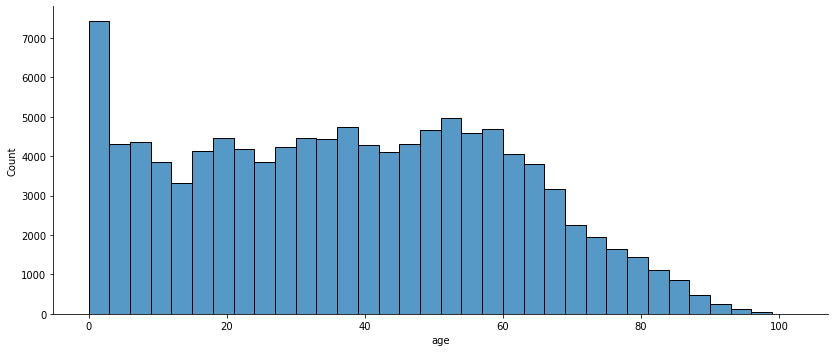

In [131]:
# view distribution of age
plot_dist(df_engineer,'age', 3)

In [182]:
# identify the age bins and labels
age_bins = [0, 1, 5, 17, 28, 44, 54, 65, 75, 102]
age_labels = ['infant', 'preschool', 'child', 'young_adult', 'adult', 'middle_aged', 'mature_adult', 'senior', '80_and_over']
# cut the data into bins
df_engineer['age_range'] = pd.cut(df_engineer['age'], bins=age_bins, labels=age_labels)
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday,days_between,days_between_cat,age_range
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,4,4,0,same_day,mature_adult
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,4,4,0,same_day,mature_adult
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,4,4,0,same_day,mature_adult
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,4,4,0,same_day,child
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,4,4,0,same_day,mature_adult


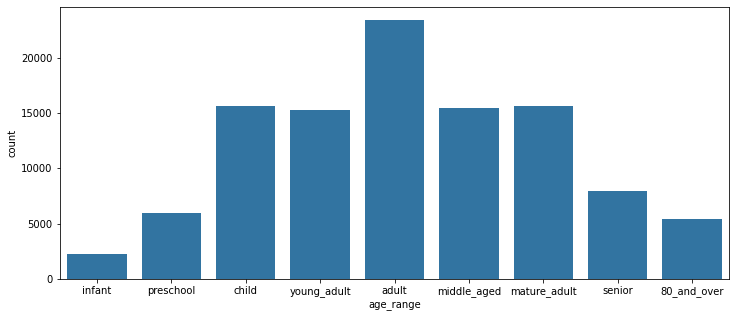

In [186]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_engineer, x='age_range');

**Days Between**

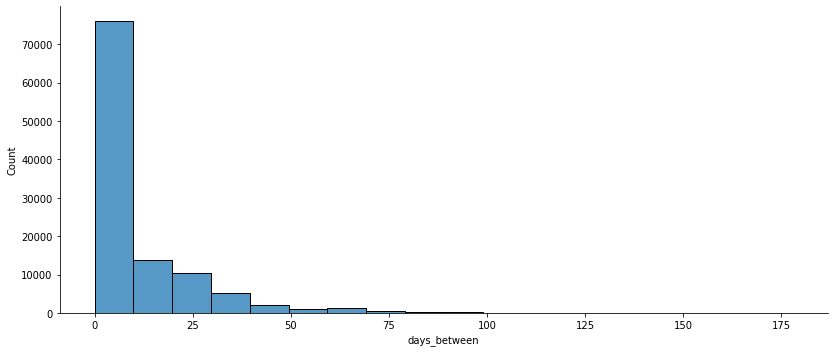

In [181]:
plot_dist(df_engineer, 'days_between', 10)

In [199]:
days_bins = [0, 1, 8, 31, 180]
days_labels = ['same_day', 'first_week', 'one_month', 'greater_than_one_month']
df_engineer['days_range'] = pd.cut(df_engineer['days_between'], bins=days_bins, labels=days_labels, right=False)

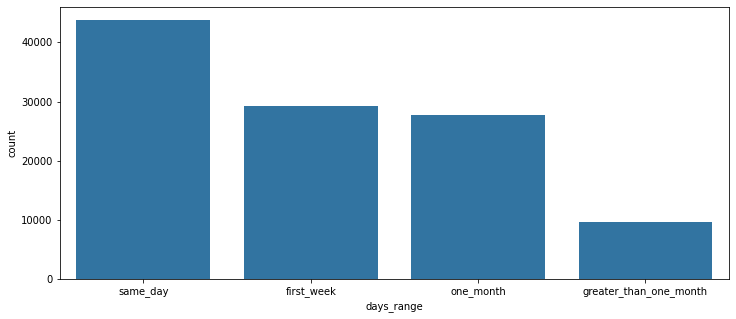

In [200]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_engineer, x='days_range');

#### Disability Count
`disability_count` is an ordinal variable. As it is an int, no further engineering is required.


#### Categorical Variables

The rest of the variables are categorical variables. `scholarship`, `hypertension`, `diabetes`, `alcoholism`, and `sms_received` are already integer binary variables, so they require no additional engineering. `no_show` will need to be converted to a binary column. `gender`, `neighbourhood`, `age_range`, and `days_range` will need One Hot Encoding later for statistical testing.
    

In [201]:
df_engineer.head()

,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday,days_between,age_range,days_range
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,0,4,4,0,mature_adult,same_day
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,0,4,4,0,mature_adult,same_day
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,0,4,4,0,mature_adult,same_day
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,4,4,0,child,same_day
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,0,4,4,0,mature_adult,same_day


**Map `no_show` to binary values**

In [189]:
df_engineer['no_show'].unique()

array(['No', 'Yes'], dtype=object)

In [190]:
# map no_show to binary values
df_engineer['no_show'] = df_engineer['no_show'].replace({'No': 0, 'Yes': 1})

In [194]:
df_engineer['no_show'].unique()

array([0, 1], dtype=int64)

Review correlation with existing binary variables

In [191]:
df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False)

,no_show
no_show,1.000000
days_between,0.180144
sms_received,0.126552
scholarship,0.029182
scheduled_weekday,0.006024
appointment_weekday,0.001184
alcoholism,-0.000173
disability_count,-0.006594
diabetes,-0.015146
hypertension,-0.035631


<Axes: >

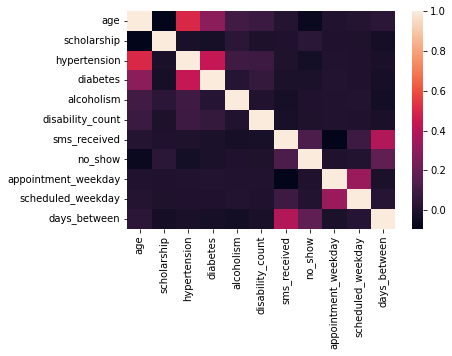

In [192]:
sns.heatmap(df_engineer.corr())

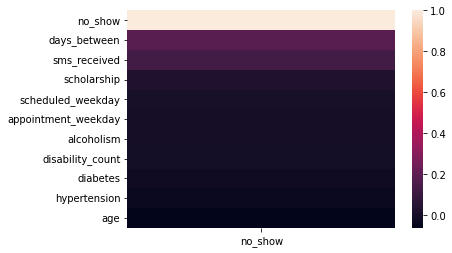

In [196]:
sns.heatmap(df_engineer.corr()[['no_show']].sort_values(by='no_show', ascending=False));

In [202]:
df_engineer = pd.get_dummies(df_engineer, ['gender', 'neighbourhood', 'age_range', 'days_range'])

In [203]:
df_engineer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110516 entries, 0 to 110526
Columns: 107 entries, age to days_range_greater_than_one_month
dtypes: int32(1), int64(10), uint8(96)
memory usage: 23.8 MB


In [204]:
df_engineer.head()

,age,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,62,0,1,0,0,0,0,0,4,4,...,0,0,0,1,0,0,1,0,0,0
1,56,0,0,0,0,0,0,0,4,4,...,0,0,0,1,0,0,1,0,0,0
2,62,0,0,0,0,0,0,0,4,4,...,0,0,0,1,0,0,1,0,0,0
3,8,0,0,0,0,0,0,0,4,4,...,0,0,0,0,0,0,1,0,0,0
4,56,0,1,1,0,0,0,0,4,4,...,0,0,0,1,0,0,1,0,0,0


In [205]:
df_engineer.describe()

,age,scholarship,hypertension,diabetes,alcoholism,disability_count,sms_received,no_show,appointment_weekday,scheduled_weekday,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
count,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,...,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000,110516.000000
mean,37.085861,0.098275,0.197257,0.071872,0.030403,0.022196,0.321049,0.201880,1.858274,1.851985,...,0.138677,0.211951,0.139934,0.141409,0.071564,0.048735,0.396087,0.265138,0.250959,0.087815
std,23.104465,0.297688,0.397929,0.258277,0.171694,0.161390,0.466882,0.401405,1.371662,1.378517,...,0.345610,0.408692,0.346921,0.348445,0.257766,0.215315,0.489085,0.441409,0.433567,0.283027
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,102.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Selection




In [206]:
from sklearn.feature_selection import chi2

In [264]:
X_cont = df_engineer.drop('no_show', axis=1)
y = df_engineer['no_show']
chi_scores_cont = chi2(X_cont, y)
features_chi_cont = pd.DataFrame({'feature': list(X_cont.columns),
                            'chi_score': chi_scores_cont[0],
                            'p_score': chi_scores_cont[1]})
features_chi_cont.head()

,feature,chi_score,p_score
0,age,5820.615411,0.000000e+00
1,scholarship,84.867802,3.189958e-20
2,hypertension,112.633850,2.595387e-26
3,diabetes,23.530309,1.229614e-06
4,alcoholism,0.003207,9.548376e-01


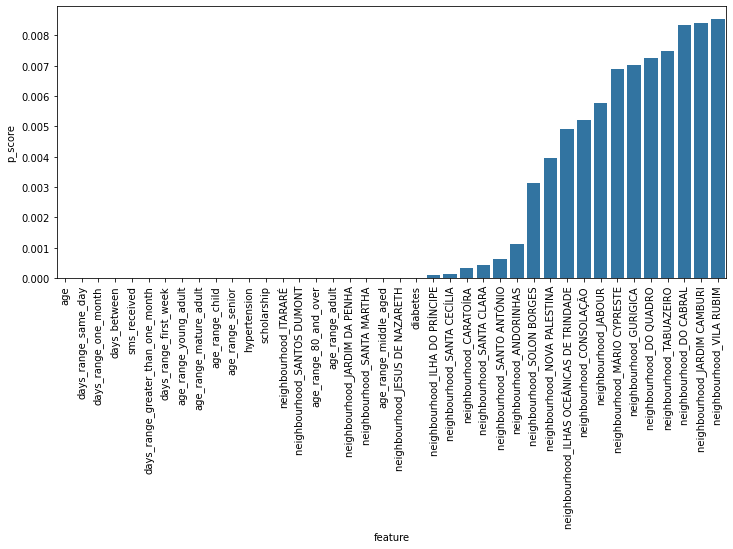

In [280]:
low_p_values_cont = features_chi_cont.query('p_score <= 0.01').sort_values(by='p_score')
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_p_values_cont['feature'], y=low_p_values_cont['p_score']);
plt.xticks(rotation='vertical');

In [281]:
low_p_values_cont.shape[0]

40

In [259]:
X = df_engineer.drop(['no_show', 'age', 'days_between'], axis=1)
y = df_engineer['no_show']
chi_scores = chi2(X_cat, y)
features_chi = pd.DataFrame({'feature': list(X_cat.columns),
                            'chi_score': chi_scores[0],
                            'p_score': chi_scores[1]})
features_chi.head()

,feature,chi_score,p_score
0,scholarship,84.867802,3.189958e-20
1,hypertension,112.633850,2.595387e-26
2,diabetes,23.530309,1.229614e-06
3,alcoholism,0.003207,9.548376e-01
4,disability_count,5.639634,1.755887e-02


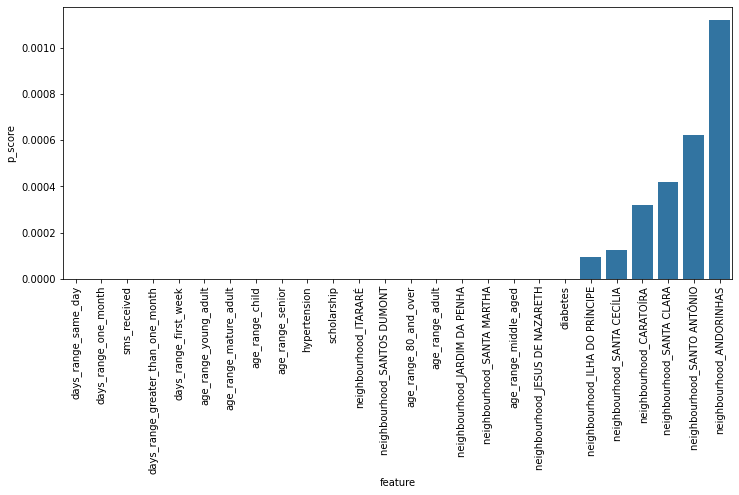

In [314]:
low_p_values = features_chi.query('p_score <= 0.01').sort_values(by='p_score')
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_p_values['feature'], y=low_p_values['p_score']);
plt.xticks(rotation='vertical');

In [276]:
low_p_values.shape[0]

38

In [283]:
high_p_values = features_chi.query('p_score > 0.01')
features_to_drop = list(high_p_values['feature'])
features_to_drop


['alcoholism',
 'disability_count',
 'appointment_weekday',
 'scheduled_weekday',
 'gender_F',
 'gender_M',
 'neighbourhood_AEROPORTO',
 'neighbourhood_ANTÔNIO HONÓRIO',
 'neighbourhood_ARIOVALDO FAVALESSA',
 'neighbourhood_BARRO VERMELHO',
 'neighbourhood_BELA VISTA',
 'neighbourhood_BENTO FERREIRA',
 'neighbourhood_BOA VISTA',
 'neighbourhood_BONFIM',
 'neighbourhood_CENTRO',
 'neighbourhood_COMDUSA',
 'neighbourhood_CONQUISTA',
 'neighbourhood_CRUZAMENTO',
 'neighbourhood_DA PENHA',
 'neighbourhood_DE LOURDES',
 'neighbourhood_DO MOSCOSO',
 'neighbourhood_ENSEADA DO SUÁ',
 'neighbourhood_ESTRELINHA',
 'neighbourhood_FONTE GRANDE',
 'neighbourhood_FORTE SÃO JOÃO',
 'neighbourhood_FRADINHOS',
 'neighbourhood_GOIABEIRAS',
 'neighbourhood_GRANDE VITÓRIA',
 'neighbourhood_HORTO',
 'neighbourhood_ILHA DAS CAIEIRAS',
 'neighbourhood_ILHA DE SANTA MARIA',
 'neighbourhood_ILHA DO BOI',
 'neighbourhood_ILHA DO FRADE',
 'neighbourhood_INHANGUETÁ',
 'neighbourhood_JOANA D´ARC',
 'neighbourhood_

In [291]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [285]:
X = df_engineer.drop(['no_show', 'age', 'days_between'], axis=1)
X.drop(features_to_drop, axis=1, inplace=True)
y = df_engineer['no_show']
X.head()

,scholarship,hypertension,diabetes,sms_received,neighbourhood_ANDORINHAS,neighbourhood_CARATOÍRA,neighbourhood_CONSOLAÇÃO,neighbourhood_DO CABRAL,neighbourhood_DO QUADRO,neighbourhood_GURIGICA,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


X

## Training and Prediction

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFECV

In preparation for the supervised learning model, I will separate the label (the `no_show` column) from the features.

In [288]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Transformed Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Transformed Training set has 88412 samples.
Testing set has 22104 samples.


In [298]:
from sklearn.metrics import fbeta_score, accuracy_score
import visuals as vs
from time import time
from IPython.display import display

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [301]:
TP = np.sum(y) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = y.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = TP/y.count()
recall = TP/(TP + FN)
precision = TP/y.count()

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + .25) * ((precision * recall) / ((.25 * precision) + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2019, F-score: 0.2402]


RandomForestClassifier trained on 884 samples.
RandomForestClassifier trained on 8841 samples.
RandomForestClassifier trained on 88412 samples.
MultinomialNB trained on 884 samples.
MultinomialNB trained on 8841 samples.
MultinomialNB trained on 88412 samples.
LogisticRegression trained on 884 samples.
LogisticRegression trained on 8841 samples.
LogisticRegression trained on 88412 samples.


C:\Users\Amanda\OneDrive\Documents\wgu\Capstone\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


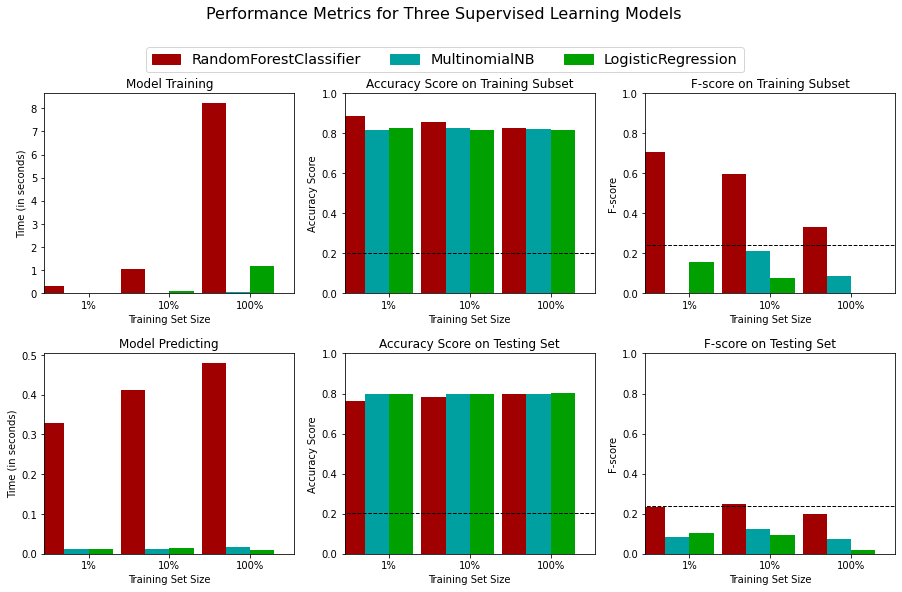

In [302]:
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = MultinomialNB()
clf_C = LogisticRegression(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.10)
samples_1 = int(len (y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [303]:
naive_bayes = MultinomialNB()
rf_mod = RandomForestClassifier(n_estimators=200, random_state=0)
lr = LogisticRegression(random_state=42)

In [304]:
naive_bayes.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [306]:
nb_preds = naive_bayes.predict(X_test)
rf_preds = rf_mod.predict(X_test)
lr_preds = lr.predict(X_test)

In [313]:
print(accuracy_score(y_test, nb_preds))
print(fbeta_score(y_test, nb_preds, beta=1))

0.7990408975750996
0.03308663474096648


In [310]:
print(accuracy_score(y_test, rf_preds))
print(fbeta_score(y_test, rf_preds, beta=2))

0.7961002533478103
0.07453721400098291


In [311]:
print(accuracy_score(y_test, lr_preds))
print(fbeta_score(y_test, lr_preds, beta=2))

0.8001719145855953
0.005362686988427887


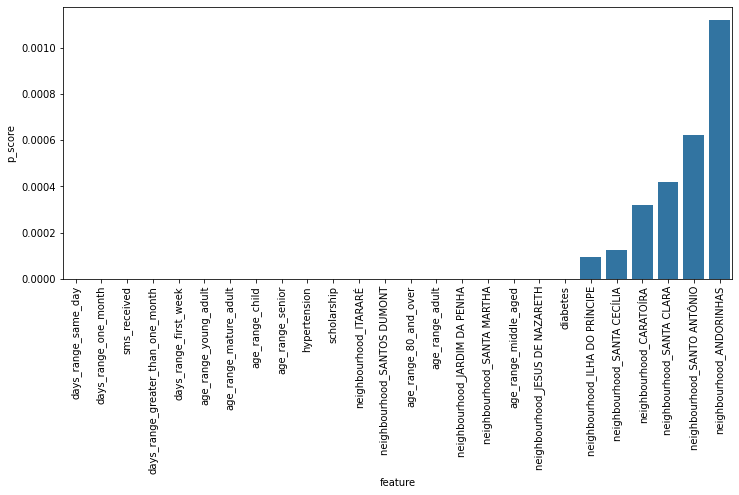

In [315]:
low_p_values = features_chi.query('p_score <= 0.002').sort_values(by='p_score')
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x=low_p_values['feature'], y=low_p_values['p_score']);
plt.xticks(rotation='vertical');

In [316]:
low_p_values.shape[0]

26

In [317]:
high_p_values = features_chi.query('p_score > 0.002')
features_to_drop = list(high_p_values['feature'])
features_to_drop

['alcoholism',
 'disability_count',
 'appointment_weekday',
 'scheduled_weekday',
 'gender_F',
 'gender_M',
 'neighbourhood_AEROPORTO',
 'neighbourhood_ANTÔNIO HONÓRIO',
 'neighbourhood_ARIOVALDO FAVALESSA',
 'neighbourhood_BARRO VERMELHO',
 'neighbourhood_BELA VISTA',
 'neighbourhood_BENTO FERREIRA',
 'neighbourhood_BOA VISTA',
 'neighbourhood_BONFIM',
 'neighbourhood_CENTRO',
 'neighbourhood_COMDUSA',
 'neighbourhood_CONQUISTA',
 'neighbourhood_CONSOLAÇÃO',
 'neighbourhood_CRUZAMENTO',
 'neighbourhood_DA PENHA',
 'neighbourhood_DE LOURDES',
 'neighbourhood_DO CABRAL',
 'neighbourhood_DO MOSCOSO',
 'neighbourhood_DO QUADRO',
 'neighbourhood_ENSEADA DO SUÁ',
 'neighbourhood_ESTRELINHA',
 'neighbourhood_FONTE GRANDE',
 'neighbourhood_FORTE SÃO JOÃO',
 'neighbourhood_FRADINHOS',
 'neighbourhood_GOIABEIRAS',
 'neighbourhood_GRANDE VITÓRIA',
 'neighbourhood_GURIGICA',
 'neighbourhood_HORTO',
 'neighbourhood_ILHA DAS CAIEIRAS',
 'neighbourhood_ILHA DE SANTA MARIA',
 'neighbourhood_ILHA DO B

In [319]:
X = df_engineer.drop(['no_show', 'age', 'days_between'], axis=1)
X.drop(features_to_drop, axis=1, inplace=True)
y = df_engineer['no_show']
X.head()

,scholarship,hypertension,diabetes,sms_received,neighbourhood_ANDORINHAS,neighbourhood_CARATOÍRA,neighbourhood_ILHA DO PRÍNCIPE,neighbourhood_ITARARÉ,neighbourhood_JARDIM DA PENHA,neighbourhood_JESUS DE NAZARETH,...,age_range_young_adult,age_range_adult,age_range_middle_aged,age_range_mature_adult,age_range_senior,age_range_80_and_over,days_range_same_day,days_range_first_week,days_range_one_month,days_range_greater_than_one_month
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0


In [320]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Transformed Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Transformed Training set has 88412 samples.
Testing set has 22104 samples.


RandomForestClassifier trained on 884 samples.
RandomForestClassifier trained on 8841 samples.
RandomForestClassifier trained on 88412 samples.
MultinomialNB trained on 884 samples.
MultinomialNB trained on 8841 samples.
MultinomialNB trained on 88412 samples.
AdaBoostClassifier trained on 884 samples.
AdaBoostClassifier trained on 8841 samples.
AdaBoostClassifier trained on 88412 samples.


C:\Users\Amanda\OneDrive\Documents\wgu\Capstone\visuals.py:121: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


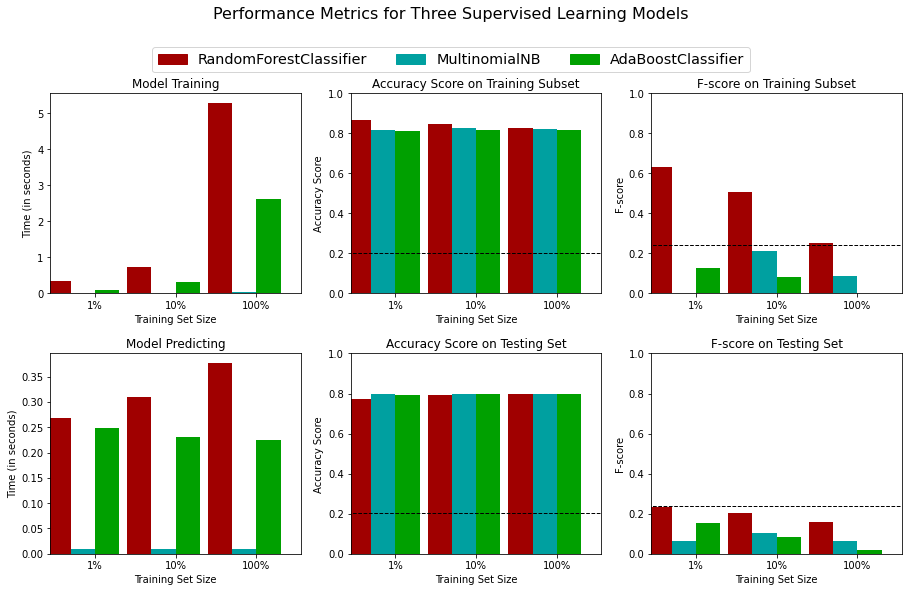

In [332]:
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = MultinomialNB()
clf_C = AdaBoostClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.10)
samples_1 = int(len (y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [322]:
naive_bayes = MultinomialNB()
rf_mod = RandomForestClassifier(n_estimators=200, random_state=0)
lr = LogisticRegression(random_state=42)

In [323]:
naive_bayes.fit(X_train, y_train)
rf_mod.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [324]:
nb_preds = naive_bayes.predict(X_test)
rf_preds = rf_mod.predict(X_test)
lr_preds = lr.predict(X_test)

In [325]:
print(accuracy_score(y_test, nb_preds))
print(fbeta_score(y_test, nb_preds, beta=1))

0.7996290264205573
0.026807295099978028


In [326]:
print(accuracy_score(y_test, rf_preds))
print(fbeta_score(y_test, rf_preds, beta=2))

0.7983170466883822
0.05113887660327288


In [327]:
print(accuracy_score(y_test, lr_preds))
print(fbeta_score(y_test, lr_preds, beta=2))

0.7999457111834962
0.003952569169960475


In [330]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)
ada_preds = ada.predict(X_test)
print(accuracy_score(y_test, ada_preds))
print(fbeta_score(y_test, ada_preds, beta=2))

0.7999004705030763
0.004515946937623483


In [328]:
# random forest feature selection
rfecv_forest = RFECV(estimator=RandomForestClassifier(random_state=42), cv=5)
rfecv_forest.fit(X, y)
for i, col in zip(range(X.shape[10], X.columns)):
    print('{}: Selected = {}/nRank= {}'.format(col, rfecv_forest.support_[i], rfecv_forest.ranking_[i]))

KeyboardInterrupt: 

In [ ]:
# naive bayes feature selection
estimator_nb = MultinomialNB()
rfecv_nb = RFECV(estimator=estimator_nb, cv=5)
rfecv_nb.fit(X, y)
for i, col in zip(range(X.shape[10], X.columns)):
    print('{}: Selected = {}/nRank= {}'.format(col, rfecv_nb.support_[i], rfecv_nb.ranking_[i]))

In [ ]:
# Logistic Regression feature selection
estimator_lr = LogisticRegression()
rfecv_lr = RFECV(estimator=estimator_lr, cv=5)
rfecv_lr.fit(X, y)
for i, col in zip(range(X.shape[10], X.columns)):
    print('{}: Selected = {}/nRank= {}'.format(col, rfecv_lr.support_[i], rfecv_lr.ranking_[i]))

In [ ]:
forest_selected_features = rfecv_forest.support_
nb_selected_features = rfecv_nb.support_
lr_selected_features = rfecv_lr.support_

In [ ]:
print("Random Forest Features: {} /nNaive Bayes Features: {} /nLogistic Regression Features: {}".format(forest_selected_features, nb_selected_features, lr_selected_features)
)

<a id='conclusions'></a>
## Conclusions

#### Factors Associated with No Shows

As can be seen in these charts, when the proportions of no shows for different patient characteristics are compared, there are some interesting results. These charts indicate the proportion of patients who have no-showed based on each of the different characteristics available in the dataset, with the exception of neighborhood.

In [ ]:
finalcharts()

In [ ]:
finalagechart()

The proportion of no shows is roughly even for gender and alcoholism status, making it appear that there is little relationship between these characteristics and not attending the appointments.

Having a scholarship or receiving a text message appears to be positively related with not showing up for an appointment.

Having Diabetes or Hypertension have a negative relationship with no shows. Having 1 disability also has a negative relationship with no shows, but it appears that the more disabilities the patient has, the more likely they were to have no showed for their appointment.

Age has a positive skew, indicating that younger patients tend to no show more frequently.

##### Limitations

An important limitation when viewing these charts is that these are all univariate analyses. In reality, the appointments actually represent patients with multiple characteristics that would interact. For example, a patient with diabetes, hypertension and alcoholism may look very different from a patient with just diabetes and hypertension. In addition, these are correlational rather than causal relationships. Performing analyses between how all of these factors interact, particularly in situations where patients may have multiple characteristics, would be interesting future research.

#### SMS Messages and No Shows

The SMS Received relationship with no shows is really interesting. We would definitely expect patients who receive text message reminders to be more likely to attend their appointments. However, since the chart above only explores the relationship between no shows and receipt of a text message, it does not take into consideration other factors that could very much impact the relationships. One thing to be aware of from reviewing the data related to the number of days between scheduling the appointment and the appointment, itself, is that SMS messages were not sent for patients who scheduled their appointment on the same day as the appointment. Since appointments scheduled on the same day of the appointment accounted for a large number of the appointments, it is helpful to dig deeper to see if receiving a text message reminder is actually more likely to be associated with having missed the appointment.

In [ ]:
finalSMSChart()

As can be seen here, receiving a SMS Reminder appears to have a more positive relationship with no shows than not receiving one.

##### Limitations

As with above, this is a shallow view of the data that does not take all of the interactions between the different patient characteristics into consideration. It is possible that SMS Reminders might show more of a positive relationship for a certain subset of the population who would otherwise be unlikely to attend. It is also possible that they may have no correlation at all for another subset. Critically, we cannot draw any causal relationships between receiving a text message reminder and appointment attendance based on these analyses. In order to draw more valid conclusions, additional research and analysis that compares the different patient characteristics would also be helpful.

<a id='sources'></a>
## Sources

To understand the Scholarship column, which indicates enrollment in Bolsa Familia 
[Wikipedia Article](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia) 
[World Without Poverty Bolsa Familia Webpage](http://wwp.org.br/en/social-policy/bolsa-familia/) 
[World Without Poverty Bolsa Familia Program Sheet](inthttps://wwp.org.br/wp-content/uploads/02.-BFP-Program-Sheet.pdf)

For additional details about the data set, including the data dictionary:
https://www.kaggle.com/datasets/joniarroba/noshowappointments

For Markdown:
https://wordpress.com/support/markdown-quick-reference/
https://www.markdownguide.org/extended-syntax/
https://www.tablesgenerator.com/markdown_tables#
https://stackoverflow.com/questions/51573722/nested-numbered-list-do-not-break-line-in-jupyter-notebook-markdown

For plotting:
Pie Charts: https://matplotlib.org/2.0.2/examples/pie_and_polar_charts/pie_demo_features.html
Line Chart: https://www.statology.org/plot-multiple-lines-matplotlib/

For figures:
https://www.tutorialspoint.com/setting-the-same-axis-limits-for-all-subplots-in-matplotlib
https://matplotlib.org/stable/users/explain/figures.html#figure-explanation
https://matplotlib.org/stable/gallery/ticks/tick-locators.html

## OPTIONAL: Question for the reviewer
 
If you have any question about the starter code or your own implementation, please add it in the cell below. 

For example, if you want to know why a piece of code is written the way it is, or its function, or alternative ways of implementing the same functionality, or if you want to get feedback on a specific part of your code or get feedback on things you tried but did not work.

Please keep your questions succinct and clear to help the reviewer answer them satisfactorily. 

> **_Your question_**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])